
Missing values before preprocessing:
SystemCodeNumber    0
Capacity            0
Occupancy           0
LastUpdated         0
dtype: int64

Missing values after preprocessing:
SystemCodeNumber    0
Capacity            0
Occupancy           0
LastUpdated         0
Hour                0
Minute              0
DayOfWeek           0
IsWeekend           0
OccupancyRate       0
dtype: int64

Dataset shape after preprocessing: (35717, 9)
Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35717 entries, 0 to 35716
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SystemCodeNumber  35717 non-null  object        
 1   Capacity          35717 non-null  int64         
 2   Occupancy         35717 non-null  int64         
 3   LastUpdated       35717 non-null  datetime64[ns]
 4   Hour              35717 non-null  int64         
 5   Minute            35717 non-null  int64         
 6   DayOfW

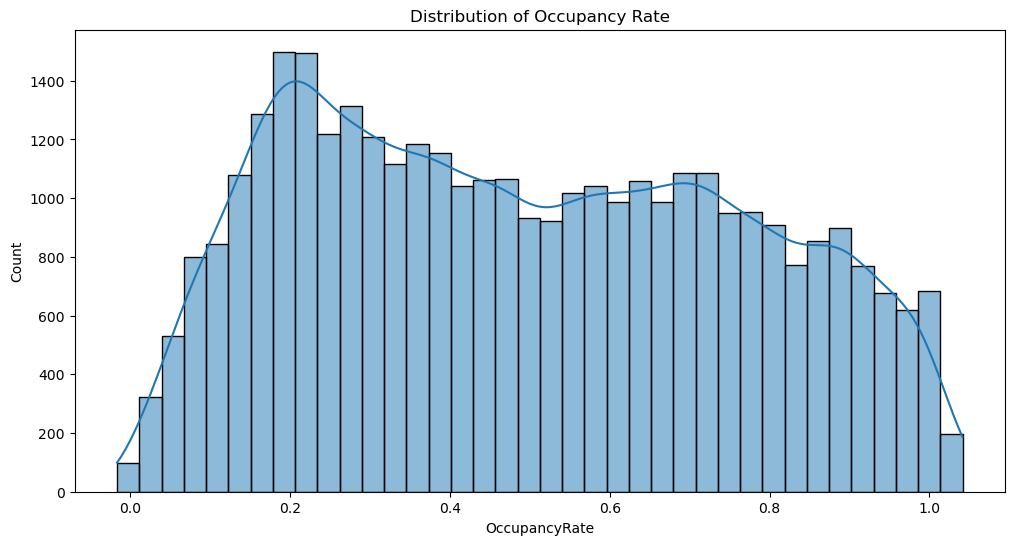

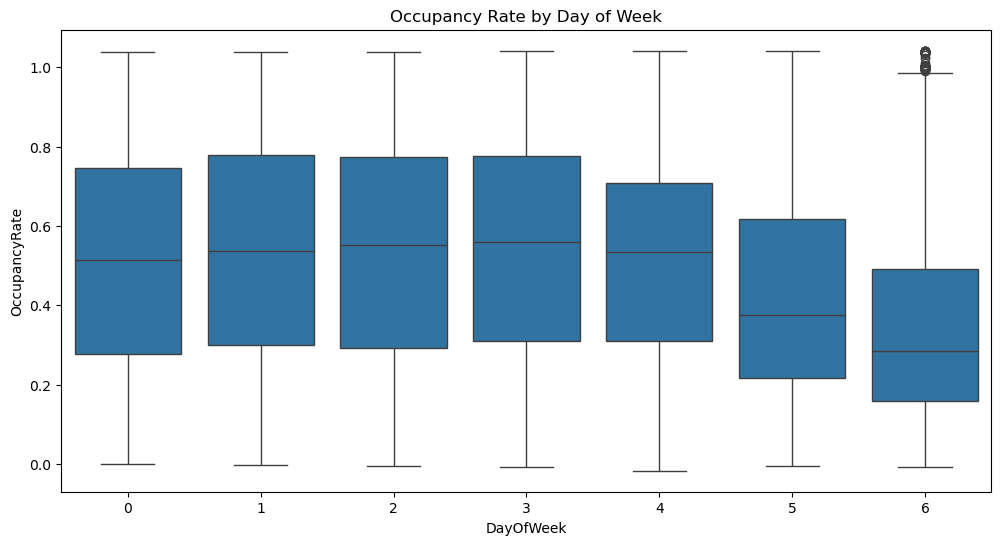

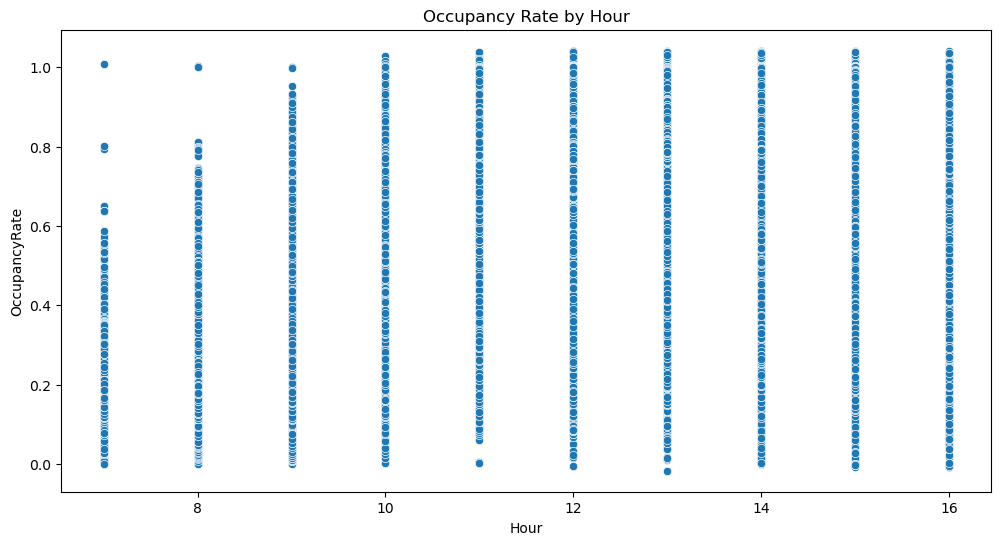

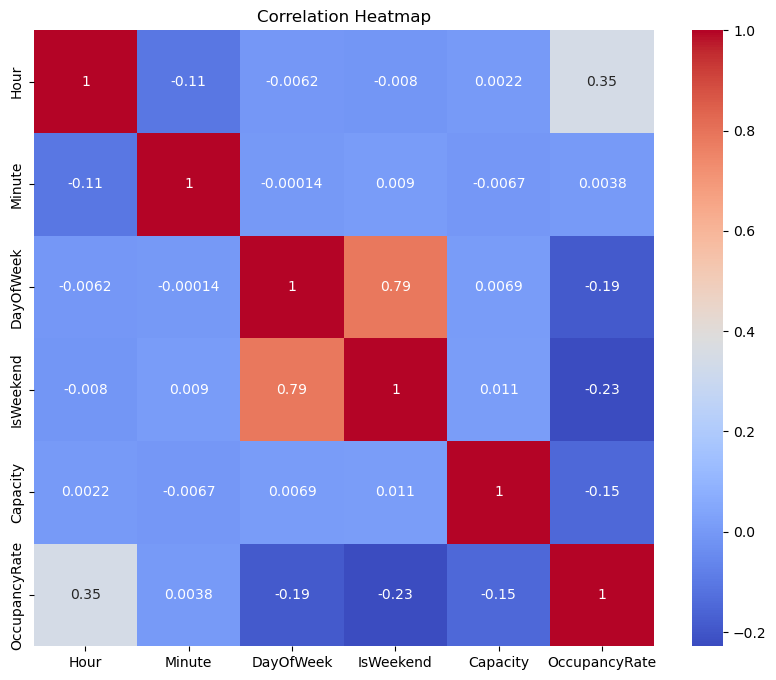


Model Performance Metrics:
--------------------------------------------------------------------------------
Model           | MSE        | R2 Score   | Accuracy   | Precision  | Recall     | F1 Score  
---------------------------------------------------------------------------------------------
XGBoost         | 0.0091     | 0.8755     | 0.9176     | 0.9176     | 0.9176     | 0.9176    
RandomForest    | 0.0082     | 0.8878     | 0.9225     | 0.9225     | 0.9225     | 0.9225    
LinearRegression | 0.0595     | 0.1887     | 0.6620     | 0.6626     | 0.6620     | 0.6621    
SVR             | 0.0494     | 0.3263     | 0.7349     | 0.7419     | 0.7349     | 0.7345    


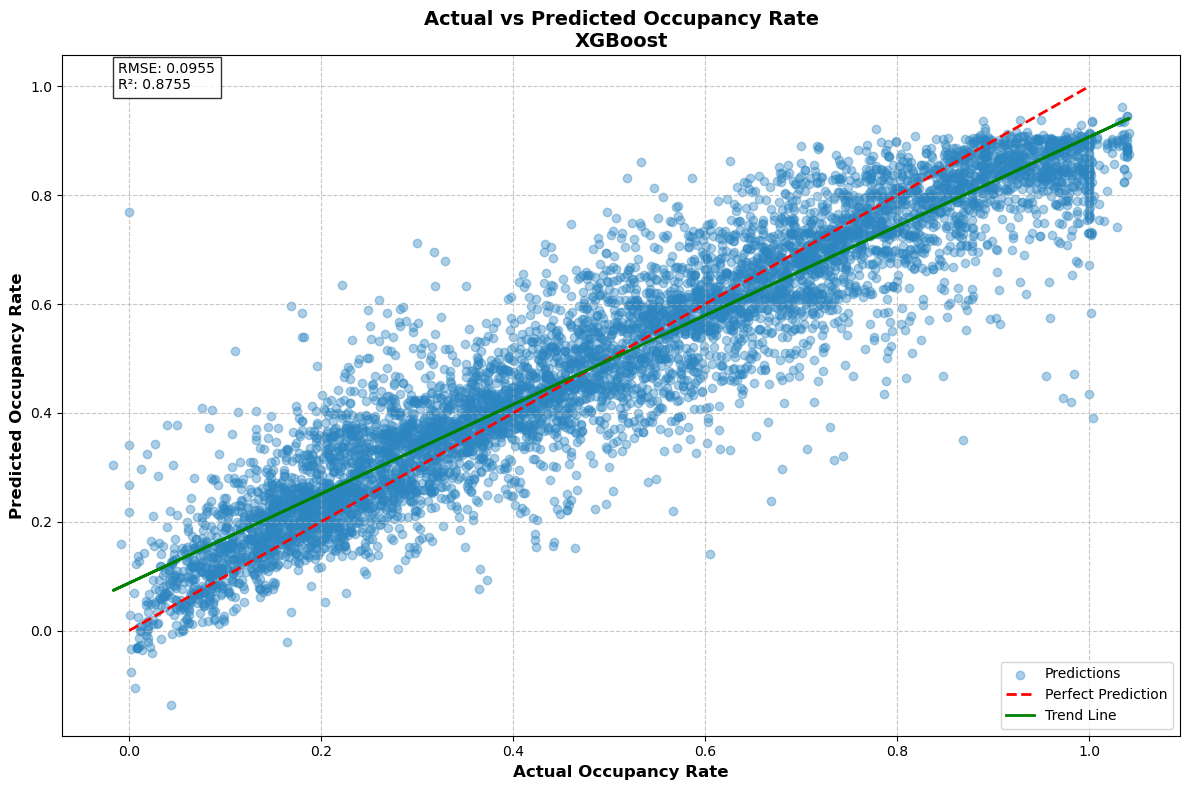

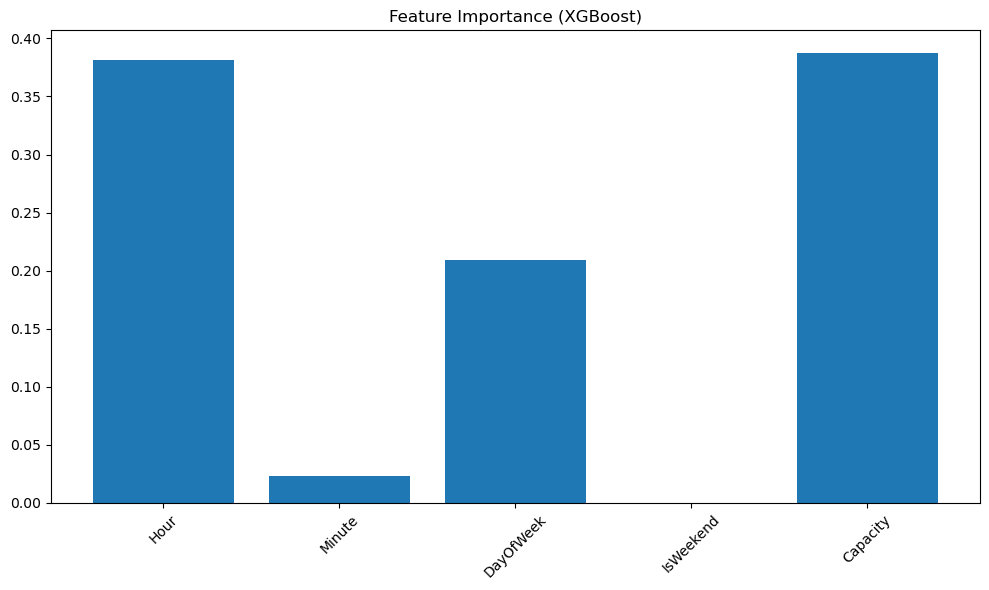

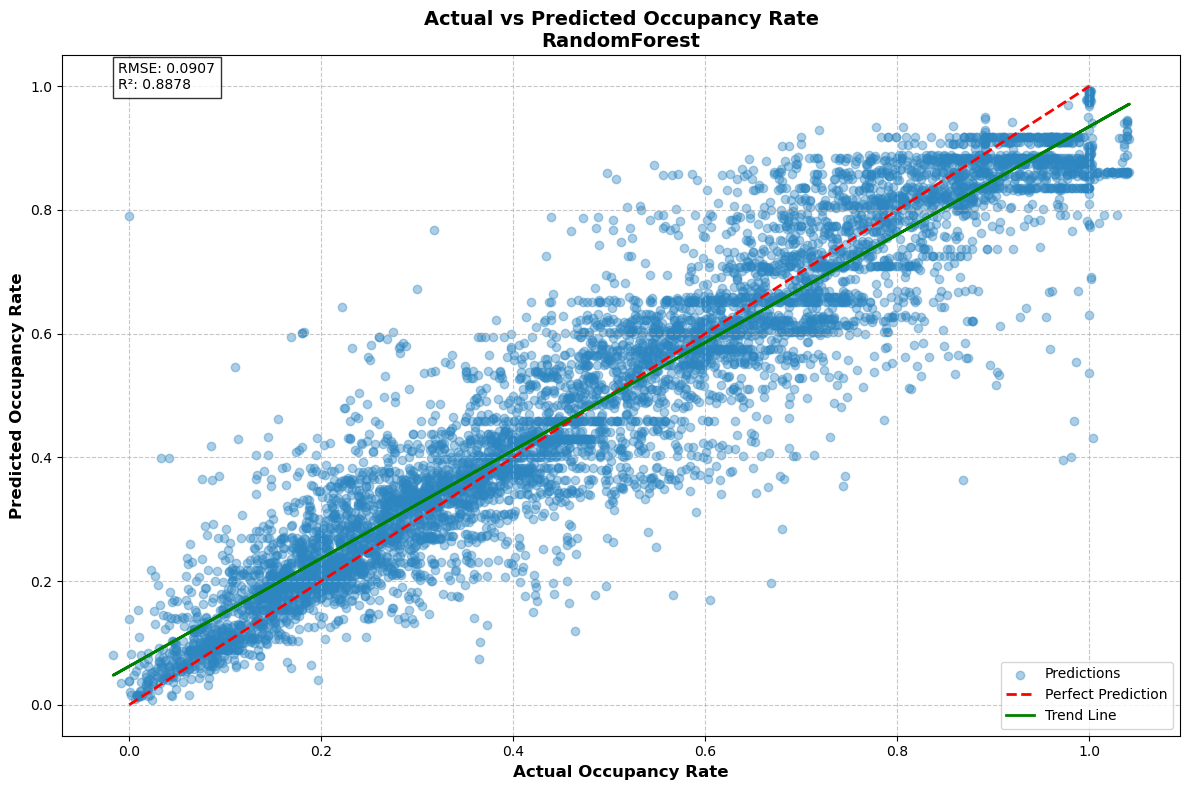

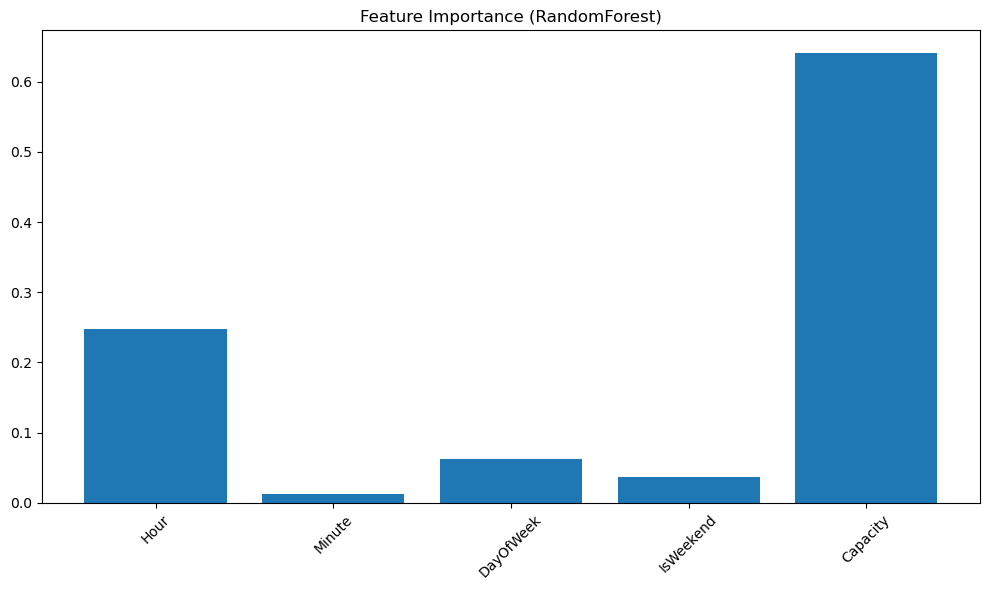

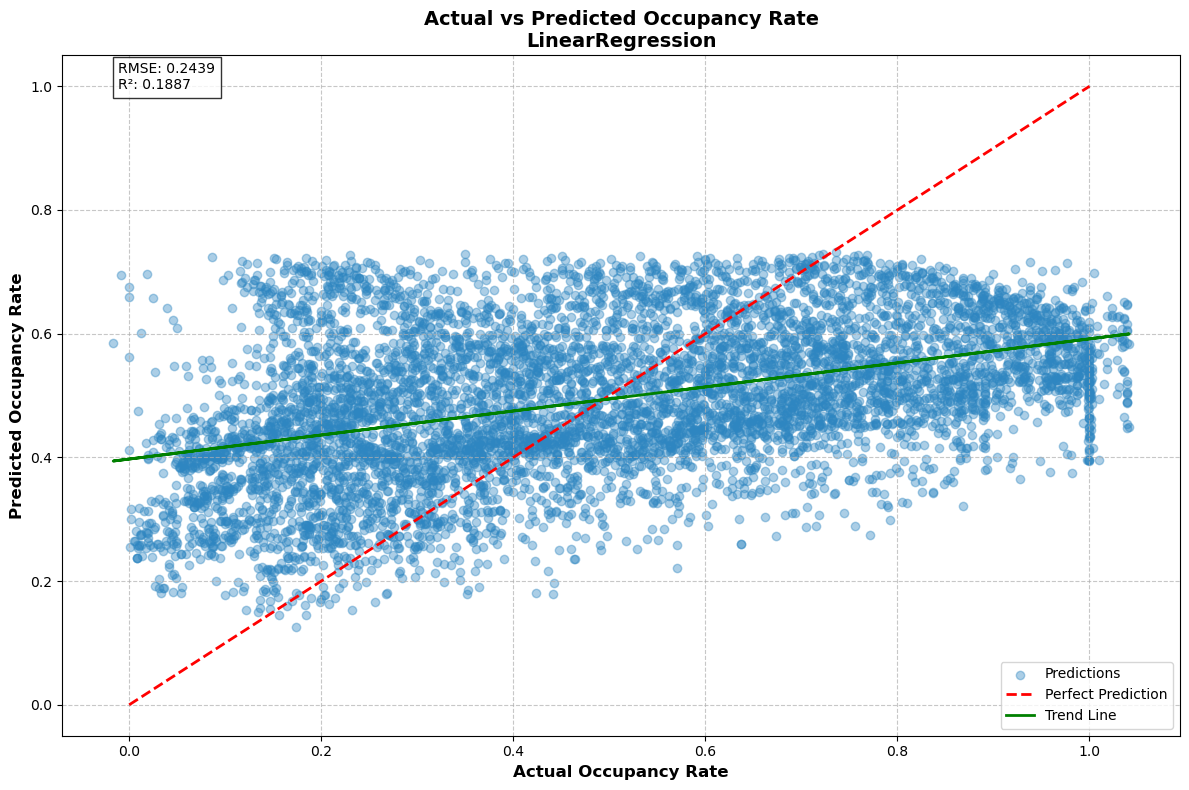

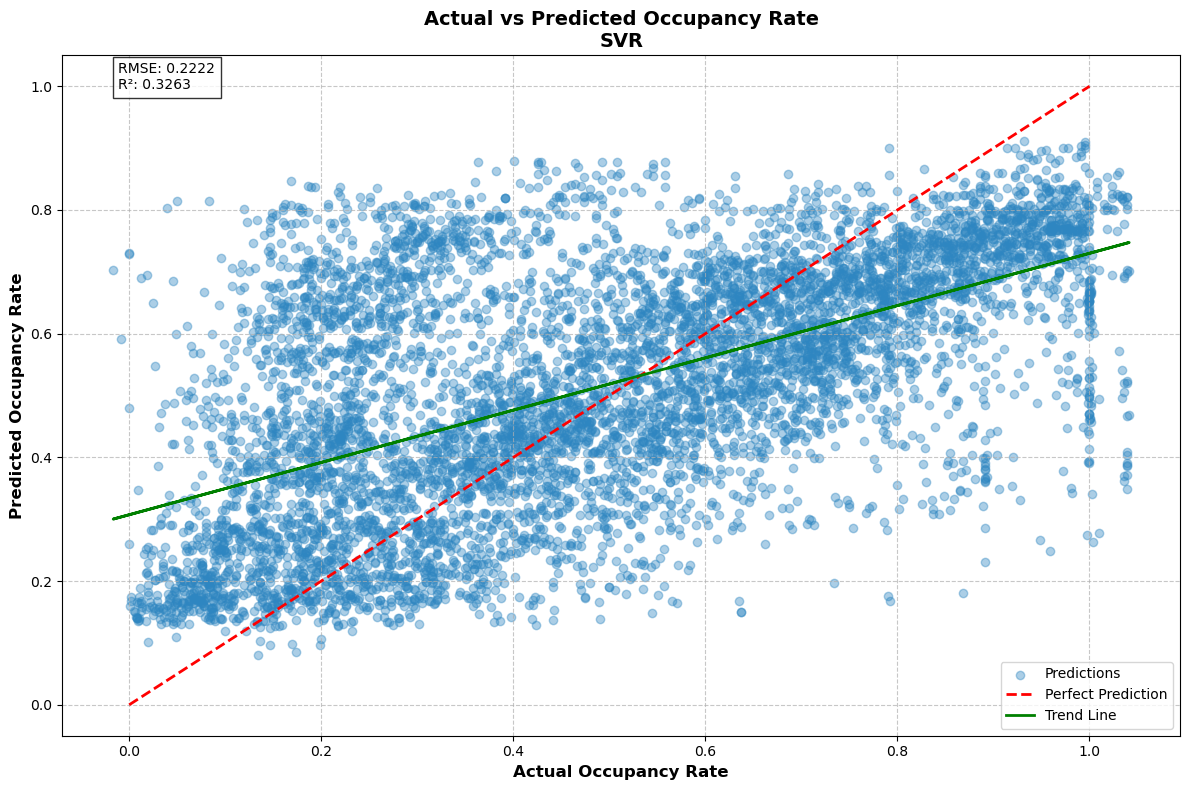

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    # Print initial missing values
    print("\nMissing values before preprocessing:")
    print(df.isnull().sum())
    
    # Handle missing values
    # Fill numeric columns with median
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_columns:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Drop rows where LastUpdated is null as it's crucial for feature engineering
    df.dropna(subset=['LastUpdated'], inplace=True)
    
    # Convert LastUpdated to datetime
    df['LastUpdated'] = pd.to_datetime(df['LastUpdated'])
    
    # Create time-based features
    df['Hour'] = df['LastUpdated'].dt.hour
    df['Minute'] = df['LastUpdated'].dt.minute
    df['DayOfWeek'] = df['LastUpdated'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    
    # Calculate occupancy rate after handling missing values
    df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
    
    # Remove any rows with infinite values that might have been created
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    
    # Print final missing values check
    print("\nMissing values after preprocessing:")
    print(df.isnull().sum())
    
    # Print shape of dataset before and after preprocessing
    print(f"\nDataset shape after preprocessing: {df.shape}")
    
    return df

def explore_data(df):
    print("Data Overview:")
    print(df.info())
    print("\nDescriptive Statistics:")
    print(df.describe())
    
    plt.figure(figsize=(12, 6))
    sns.histplot(df['OccupancyRate'], kde=True)
    plt.title('Distribution of Occupancy Rate')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='DayOfWeek', y='OccupancyRate', data=df)
    plt.title('Occupancy Rate by Day of Week')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Hour', y='OccupancyRate', data=df)
    plt.title('Occupancy Rate by Hour')
    plt.show()
    
    correlation_matrix = df[['Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Capacity', 'OccupancyRate']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

def create_features(df):
    features = ['Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Capacity']
    X = df[features]
    y = df['OccupancyRate']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=features)
    return X_scaled, y

def calculate_performance_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    y_test_binary = (y_test > 0.5).astype(int)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    precision = precision_score(y_test_binary, y_pred_binary, average='weighted')
    recall = recall_score(y_test_binary, y_pred_binary, average='weighted')
    f1 = f1_score(y_test_binary, y_pred_binary, average='weighted')
    
    return {
        'MSE': mse,
        'R2 Score': r2,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

def train_models(X_train, X_test, y_train, y_test):
    models = {
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5),
        'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        'LinearRegression': LinearRegression(),
        'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = calculate_performance_metrics(y_test, y_pred)
        results[name] = {'model': model, 'metrics': metrics}
    
    return results

def plot_predictions(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot with lower opacity and darker color
    plt.scatter(y_test, y_pred, alpha=0.4, color='#2E86C1', label='Predictions')
    
    # Add perfect prediction line
    plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction', linewidth=2)
    
    # Add trend line
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), "g-", label='Trend Line', linewidth=2)
    
    # Customize the plot
    plt.xlabel('Actual Occupancy Rate', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted Occupancy Rate', fontsize=12, fontweight='bold')
    plt.title(f'Actual vs Predicted Occupancy Rate\n{model_name}', fontsize=14, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(fontsize=10)
    
    # Add text box with interpretation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    stats_text = f'RMSE: {rmse:.4f}\nR²: {r2:.4f}'
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.bar(feature_names, importance)
        plt.title(f'Feature Importance ({model_name})')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def display_results(results):
    print("\nModel Performance Metrics:")
    print("-" * 80)
    
    metrics = next(iter(results.values()))['metrics'].keys()
    header = "Model".ljust(15) + " | " + " | ".join(str(metric).ljust(10) for metric in metrics)
    print(header)
    print("-" * len(header))
    
    for name, result in results.items():
        metrics_values = result['metrics']
        metrics_str = " | ".join(f"{value:.4f}".ljust(10) for value in metrics_values.values())
        print(f"{name.ljust(15)} | {metrics_str}")

def main():
    df = load_and_preprocess_data('dataset.csv')
    explore_data(df)
    
    X, y = create_features(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results = train_models(X_train, X_test, y_train, y_test)
    
    display_results(results)
    
    for name, result in results.items():
        plot_predictions(result['model'], X_test, y_test, name)
        plot_feature_importance(result['model'], X.columns, name)

if __name__ == "__main__":
    main()